Bigger than 200.. R_2z6z1mP8PKgRmNl
354
Bigger than 200.. R_2z6z1mP8PKgRmNl
403
Bigger than 200.. R_2z6z1mP8PKgRmNl
320
Bigger than 200.. R_2z6z1mP8PKgRmNl
455
Bigger than 200.. R_2z6z1mP8PKgRmNl
449
Low data qual R_1LUQskcdcI8Wopy
1800
Bigger than 200.. R_1LUQskcdcI8Wopy
449
Bigger than 200.. R_2DNtv2Myk2es8al
470
Bigger than 200.. R_1li7ZSwzwD5N8aG
327
Bigger than 200.. R_1li7ZSwzwD5N8aG
428
Bigger than 200.. R_3JEqYkmYtkeVBvM
596
Bigger than 200.. R_3JEqYkmYtkeVBvM
431
Bigger than 200.. R_3JEqYkmYtkeVBvM
756
Bigger than 200.. R_3JEqYkmYtkeVBvM
688
Bigger than 200.. R_3JEqYkmYtkeVBvM
692
Bigger than 200.. R_3pgvfRiSPHPkDYj
424
Bigger than 200.. R_2U5Rg5PhxgJYa7x
904
Bigger than 200.. R_2U5Rg5PhxgJYa7x
903
Bigger than 200.. R_2U5Rg5PhxgJYa7x
687
Bigger than 200.. R_2U5Rg5PhxgJYa7x
840
Bigger than 200.. R_2U5Rg5PhxgJYa7x
788
Bigger than 200.. R_2U5Rg5PhxgJYa7x
873
Bigger than 200.. R_2U5Rg5PhxgJYa7x
902
Bigger than 200.. R_2U5Rg5PhxgJYa7x
901
Bigger than 200.. R_2aY1wtx6tEhnFrm
901
Big

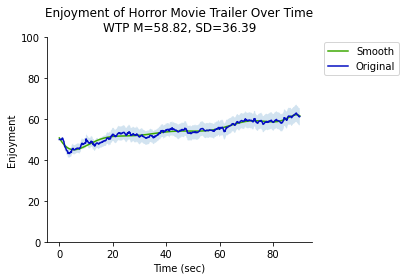

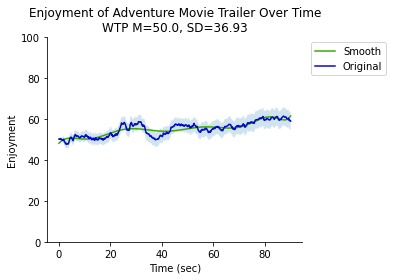

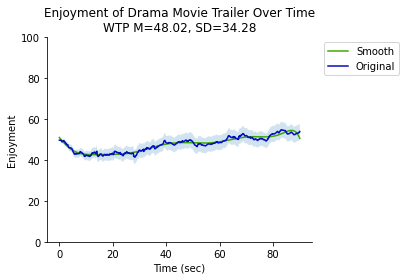

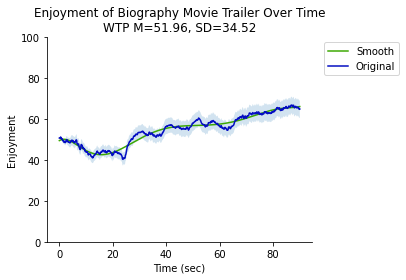

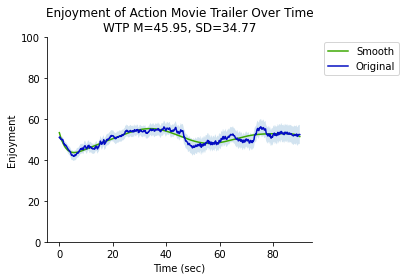

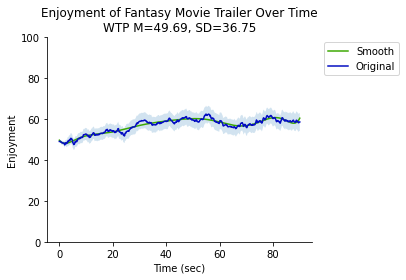

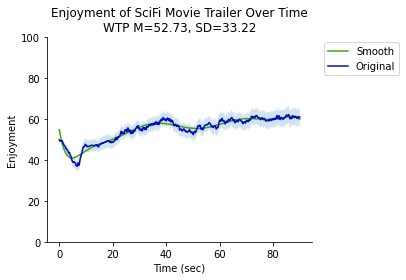

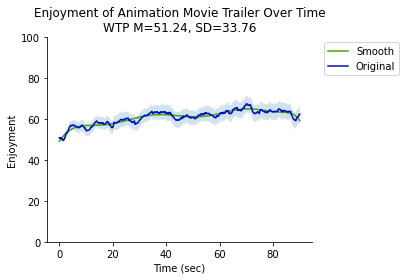

In [50]:
## Lifelines
import json

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy import signal
from scipy.stats import sem
from itertools import groupby
from scipy.integrate import quad

def plot_lines(ys, title, wtp_mean, wtp_std, mean=False):
    if mean:
        ys_mean = np.stack(ys).mean(axis=0)
        ys_sem = sem(np.stack(ys), axis=0)
    else:
        ys_mean = ys

    xs = np.linspace(0, 90, num=900)

    plt.figure()
    poly = np.polyfit(xs, ys_mean, 10)
    poly_y = np.poly1d(poly)(xs)
    plt.plot(xs, poly_y, color="#3da803", label="Smooth")
    plt.plot(xs, ys_mean, color="#040dc2", label="Original")

    if mean:
        plt.fill_between(xs, ys_mean - ys_sem, ys_mean + ys_sem, alpha=0.2)
    plt.ylabel("Enjoyment")
    plt.xlabel("Time (sec)")
    plt.title("Enjoyment of {} Movie Trailer Over Time\nWTP M={}, SD={}".format(title, str(wtp_mean), str(wtp_std)))

    plt.legend(bbox_to_anchor=(1.35, 1.0))
    plt.tight_layout()

    ax = plt.gca()
    ax.set_ylim([0, 100])
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    plt.show()

    #plt.savefig("../plots/lifeline_{}.png".format(title), dpi=1000)

data = pd.read_csv('./data/data.csv')

## Performquad(np.poly1d(np.polyfit(xs, ys_mean, 10)), 0, 100) Exclusions
data = data.drop(data[data.Finished != 'True'].index)

## All passed at least one of the two attention and comprehension checks
## Drop low connections
data = data.drop(data[data.ResponseId == 'R_10ovXcMfOnkIZYm'].index)

titles = ['Horror', 'Adventure', 'Drama', 'Biography', 'Action', 'Fantasy', 'SciFi', 'Animation']

lengths = []

def listify(row):
    row = str(row).split(',')
    row = [float(y) for y in row]

    return row

for title in titles:
    data.loc[:, '{}Enjoyment'.format(title)] = data.loc[:, '{}Enjoyment'.format(title)].apply(listify, args=())
    estr = '4' if title not in ['Action', 'Adventure'] else '1'

## Remove data with too few or many points, and exclude those who have the same enjoyments for more than 20 seconds
rms = []
for index, row in data.iterrows():
    for title in titles:
        if abs(len(row['{}Enjoyment'.format(title)]) - 900) > 300:
            print("Low data qual {}".format(row['ResponseId']))
            print(len(row['{}Enjoyment'.format(title)]))
            rms.append(row['ResponseId'])

        if max([sum(1 for i in g) for k,g in groupby(row['{}Enjoyment'.format(title)])]) > 300:
            print("Bigger than 200.. {}".format(row['ResponseId']))
            print(max([sum(1 for i in g) for k,g in groupby(row['{}Enjoyment'.format(title)])]))
            rms.append(row['ResponseId'])



rms = list(dict.fromkeys(rms))
data = data[~data['ResponseId'].isin(rms)]
print(rms)
print(len(rms))

def resample_time(row):
    return signal.resample(row, 900)

##  Resample the data to be 900 ms, and plot the graphs
for title in titles:
    data.loc[:, '{}Enjoyment'.format(title)] = data.loc[:, '{}Enjoyment'.format(title)].apply(resample_time)
    estr = '4' if title not in ['Action', 'Adventure'] else '1'
    plot_lines(data.loc[:, '{}Enjoyment'.format(title)], title='{}'.format(title), wtp_mean=round(data['{}_willing_{}'.format(title.lower(), estr)].astype(int).mean(), 2), wtp_std=round(data['{}_willing_{}'.format(title.lower(), estr)].astype(int).std(), 2), mean=True)


In [54]:
# Calculate metrics for predicting enjoyments...

xs = np.linspace(0, 90, num=900)

# Number of Peaks
def get_num_peaks(row):
    poly = np.polyfit(xs, row, 10)
    poly_y = np.poly1d(poly)(xs)

    peaks, _ = signal.find_peaks(poly_y)

    #plot_lines(row, "asd", 0, 0)
    return len(peaks)

# Number of Valleys
def get_num_valleys(row):
    poly = np.polyfit(xs, row, 10)
    poly_y = np.poly1d(poly)(xs)

    # Find peaks of negative signal ---
    peaks, _ = signal.find_peaks(-poly_y)

    #plot_lines(row, "asd", 0, 0)
    return len(peaks)

# Number of Extrema
def get_num_extrema(row):
    return get_num_peaks(row) + get_num_valleys(row)

def get_first_derivative(row):
    poly = np.polyfit(xs, row, 10)
    return json.dumps(list(np.polyder(poly)))


"""
# End Value
def get_end_value(row):
    return row[899]

# Integral
def get_integral(row):
    max_y = 1 * len(row)
    xs = [i for i in range(0, max_y, 1)]
    return quad(np.poly1d(np.polyfit(xs, row, 10)), 0, 900)[0]

def get_d1_avg_unweight(row):
    return

def get_d1_avg_weight_prime(row):
    return

def get_d1_avg_weight_asc(row):
    return

def get_d1_avg_weight_des(row):
    return

def get_d1_avg_weight_end(row):
    return

def get_d2_avg_unweight(row):
    return

def get_d2_avg_weight_prime(row):
    return

def get_d2_avg_weight_asc(row):
    return

def get_d2_avg_weight_des(row):
    return

def get_d2_avg_weight_end(row):
    return


dataframes = {}
apply_funcs = {'max': max, 'min': min, 'end_value': get_end_value, 'number_peaks': get_num_peaks, 'number_valleys': get_num_valleys, 'number_extrema': get_num_extrema, 'integral': get_integral,
               'd1_avg_unweight': get_d1_avg_unweight, 'd1_avg_weight_prime': get_d1_avg_weight_prime,
               'd1_avg_weight_asc': get_d1_avg_weight_asc, 'd1_avg_weight_des': get_d1_avg_weight_des,
               'd1_avg_weight_end': get_d1_avg_weight_end,
               'd2_avg_unweight': get_d2_avg_unweight, 'd2_avg_weight_prime': get_d2_avg_weight_prime, 'd2_avg_weight_asc': get_d2_avg_weight_asc, 'd2_avg_weight_des': get_d2_avg_weight_des, 'd2_avg_weight_end': get_d2_avg_weight_end}
for title in titles:
    dataframes[title] = pd.DataFrame()

    for k,v in apply_funcs.items():
        dataframes[title][k] = data.loc[:, '{}Enjoyment'.format(title)].apply(v)

"""

def get_poly(row):
    #plot_lines(row, "asd", 0, 0)
    return json.dumps(list(np.polyfit(xs, row, 10)))

## Save the polynomials for R
for title in titles:
    data[title + '_first_derivative'] = data.loc[:, '{}Enjoyment'.format(title)].apply(get_first_derivative)
    data[title + '_equation'] = data.loc[:, '{}Enjoyment'.format(title)].apply(get_poly)
    data[title + '_number_peaks'] = data.loc[:, '{}Enjoyment'.format(title)].apply(get_num_peaks)
    data[title + '_number_valleys'] = data.loc[:, '{}Enjoyment'.format(title)].apply(get_num_valleys)
    data[title + '_number_extrema'] = data.loc[:, '{}Enjoyment'.format(title)].apply(get_num_extrema)

data.to_csv('./data/lifelines_cleaned.csv')

In [34]:
#
#
#
#

In [ ]:
# Plot each participant separately

def plot_lines():
    for i, title in enumerate(titles):
        figure, axis = plt.subplots(1, 10)
        count = 0
        for index, row in data.iterrows():
            ys = row['{}Enjoyment'.format(title)]
            max_y = 100 * 900
            xs = [i for i in range(0, max_y, 100)]

            plt.figure()
            poly = np.polyfit(xs, ys, 10)
            poly_y = np.poly1d(poly)(xs)

            axis[count].plot(xs, poly_y, color="#3da803", label="Smooth")
            axis[count].plot(xs, ys, color="#040dc2", label="Original")
            #axis[count, i].set_title('{}Enjoyment -- {}'.format(title, count))

            count += 1
            if count == 10:
                break

        plt.show()


plot_lines()